# Scikit-learn Compatibility

---

## 1 - Introduction

`pysurvival` estimator models can be adapted to be used with [`scikit-learn`](https://scikit-learn.org/)'s cross-validation, hyperparameter optimization, and pipeline functionalities. This notebook explains, via simple examples, how to convert `pysurvival` built-in estimators to `scikit-learn`-compatible estimators and use available functionalities for the latter.

This experimental feature of `pysurvival` is inspired by the package [lifelines](https://github.com/CamDavidsonPilon/lifelines) and its module [`sklearn_adapter`](https://lifelines.readthedocs.io/en/latest/Compatibility%20with%20scikit-learn.html).

---

## 2 - Basics of Module `sklearn_adapter`

### 2.1 - Adapting a Built-in Estimator Model

An estimator model in `pysurvival` can be *adapted* and made compatible with `scikit-learn` via function `sklearn_adapter` as follows:

In [1]:
import pandas as pd
from pysurvival.datasets import Dataset
from pysurvival.utils.sklearn_adapter import sklearn_adapter
from pysurvival.utils.metrics import concordance_index
from pysurvival.models.multi_task import LinearMultiTaskModel

# Load and split a simple example into train/test sets
ds = Dataset("simple_example")
X_train, T_train, E_train, X_test, T_test, E_test = ds.load_train_test()
Y_train = pd.concat((pd.DataFrame(T_train, columns=[ds.time_column]), pd.DataFrame(E_train, columns=[ds.event_column])), axis=1)
Y_test = pd.concat((pd.DataFrame(T_test, columns=[ds.time_column]), pd.DataFrame(E_test, columns=[ds.event_column])), axis=1)

# Adapt class LinearMultiTaskModel to make it compatible with scikit-learn
LinearMultiTaskModelSkl = sklearn_adapter(LinearMultiTaskModel, time_col=ds.time_column, event_col=ds.event_column,
                                          predict_method="predict_survival", scoring_method=concordance_index)

# Instantiate an object of the new class LinearMultiTaskModelSkl
mtlr_model_skl = LinearMultiTaskModelSkl()

Note that the call to function `sklearn_adapter` requires the names of the time and event columns, because the adapted class must know how to extract the event data (specific to survival data). The name of the predict method may also be specified (refer to the documentation of each estimator for the available `predict_*` methods). The default scoring method is the `concordance_index`.

The new convention requires that the array of event data is stored in the same `DataFrame` as the time data. The adapted class properly handles this two-column `DataFrame` automatically.

### 2.2 - Model Fitting

With the exception of the non-parametric estimator (class `KaplanMeierModel`), all other estimator models' `fit` method contains three mandatory input arguments: `X` (array of predictor data), `T` (array of time data), and `E` (array of event data). The `KaplanMeierModel`' `fit` method only requires `T` and `E`. This convention is not compatible with the `fit` method of class `BaseEstimator` in `scitkit-learn`.

Now, with the adapted class, the `fit` method has the same signature as that of class `BaseEstimator` in `scitkit-learn`:

In [2]:
# Equivalent to calling method fit of class LinearMultiTaskModel
mtlr_model_skl.fit(X_train, Y_train, init_method="orthogonal", optimizer="adam", lr=1e-4)

% Completion: 100%|**********************************************|Loss: 1266.32


SkLearnLinearMultiTaskModel(auto_scaler=True, bins=100)

The only required input arguments are `X` (predictors) and `Y` (time and event). All input arguments beyond that are passed as a `fit_params` dictionary to the specific estimator model's `fit` method.

### 2.3 - Model Prediction

Predicting from a model using the adapted class works similarly to predicting from class `BaseEstimator` in `scitkit-learn`. Note that, from the call to function `sklearn_adapter`, the method whose name matches the `predict_method` name will be used.

In [3]:
# Equivalent to calling the method predict_survival of class LinearMultiTaskModel
mtlr_model_skl_y_pred = mtlr_model_skl.predict(X_test)

### 2.4 - Model Score

Similarly for calculating the model score:

In [4]:
# Equivalent to calling function concordance_index on an object of class LinearMultiTaskModel
mtlr_model_score = mtlr_model_skl.score(X_test, Y_test)
print("Scikit-learn LinearMultiTaskModel model c-index = {}".format(mtlr_model_score))

Scikit-learn LinearMultiTaskModel model c-index = 0.9579225723673247


### 2.5 - Additional Functionalities

The original built-in estimator model instance can be retrieved with the attribute `pysurvival_model`. This can be useful when obtaining disgnostics plots, for example:

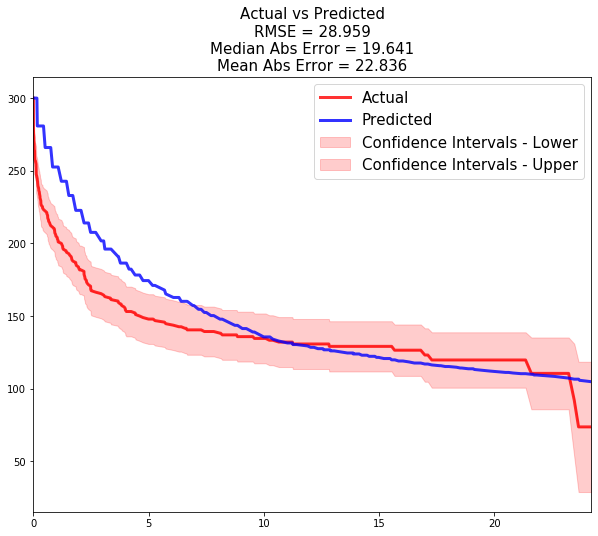

{'root_mean_squared_error': 28.95925380459718,
 'median_absolute_error': 19.640989742292277,
 'mean_absolute_error': 22.83624099875313}

In [5]:
from pysurvival.utils.display import compare_to_actual
compare_to_actual(mtlr_model_skl.pysurvival_model, X_test, T_test, E_test, is_at_risk=True, figure_size=(10, 8),
                  metrics=["rmse", "mean", "median"])

---

## 3 - Scikit-learn's Funcionalities

### 3.1 - Cross-validation Score

The following computes 5-fold cross-validation scores of an object of the adapted `LinearMultiTaskModel` class. Additional fitting parameters are passed in the dictionary `fit_params`.

In [6]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(mtlr_model_skl, X_train, Y_train, cv=5,  fit_params={"init_method": "glorot_uniform", 
                                                                              "l2_reg": 1e-2, "lr": 1e-2, 
                                                                              "tol": 1e-4, "verbose": False})
print(scores)

The gradient exploded... You should reduce the learningrate (lr) of your optimizer
The gradient exploded... You should reduce the learningrate (lr) of your optimizer
The gradient exploded... You should reduce the learningrate (lr) of your optimizer
The gradient exploded... You should reduce the learningrate (lr) of your optimizer
The gradient exploded... You should reduce the learningrate (lr) of your optimizer
[0.97162244 0.96908122 0.96863263 0.97496285 0.96817657]


### 3.2 - Hyperparameter Tuning

The following tunes a specific hyperparameter of the `fit` method of class `LinearMultiTaskModel` using grid search cross-validation.

In [7]:
from sklearn.model_selection import GridSearchCV

reg = GridSearchCV(mtlr_model_skl, {"l2_reg": [1E-2, 1E-1, 1, 10]}, cv=5)
reg.fit(X_train, Y_train)

print(reg.best_estimator_)
print(reg.best_params_)

% Completion: 100%|***********************************************|Loss: 896.70
% Completion: 100%|**********************************************|Loss: 1006.87
% Completion: 100%|***********************************************|Loss: 909.28
% Completion: 100%|**********************************************|Loss: 1061.29
% Completion: 100%|**********************************************|Loss: 1007.42
% Completion: 100%|***********************************************|Loss: 910.50
% Completion: 100%|***********************************************|Loss: 914.24
% Completion: 100%|**********************************************|Loss: 1021.68
% Completion: 100%|**********************************************|Loss: 1062.32
% Completion: 100%|***********************************************|Loss: 917.06
% Completion: 100%|***********************************************|Loss: 990.86
% Completion: 100%|**********************************************|Loss: 1071.46
% Completion: 100%|*********************

SkLearnLinearMultiTaskModel(auto_scaler=True, bins=100)
{'l2_reg': 0.1}


### 3.3 - Pipeline

The following constructs a pipeline with two steps: Principal Component Analysis (`PCA`) and an object of the adapted class `LinearMultiTaskModel`.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

estimators = [("reduce_dim", PCA()), ("reg", mtlr_model_skl)]
pipe = Pipeline(estimators)
pipe.fit(X_train, Y_train)
print(pipe)

Pipeline(memory=None,
         steps=[('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 SkLearnLinearMultiTaskModel(auto_scaler=True, bins=100))],
         verbose=False)


---

# 4 - Conclusion

In this notebook, we have shown how built-in estimator models can be adapted to be compatible with `sckikit-learn` and its functionalities.